In [55]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
import google.generativeai as genai
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data
# from models.timesfm import get_timesfm_predictions_data 

# Load environment variables from .env file
load_dotenv()

os.environ['OMP_NUM_THREADS'] = '4'

# Conditionally initialize the LLM provider
LLM_PROVIDER = os.environ.get('LLM_PROVIDER', 'gpt').lower()
if LLM_PROVIDER == 'gpt':
    api_key = os.environ.get('OPENAI_API_KEY')
    if not api_key:
        raise ValueError("OPENAI_API_KEY is not set in the .env file or environment variables.")
    openai.api_key = api_key
    openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
elif LLM_PROVIDER == 'gemini':
    api_key = os.environ.get('GEMINI_API_KEY')
    if not api_key:
        raise ValueError("GEMINI_API_KEY is not set in the .env file or environment variables.")
    genai.configure(api_key=api_key)


%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define models ##

In [57]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)

gemini_flash_hypers = dict(
    temp=0.3, 
    alpha=0.3,  
    beta=0.5,   # 안정성을 위해 중간값 강조
    top_p=0.5,
    basic=False, 
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-', half_bin_correction=True)
)

gemini_pro_hypers = dict(
    temp=0.3,   # 낮은 온도로 안정적인 예측 유도
    alpha=0.3,  # 데이터의 넓은 범위를 보고 스케일링하여 안정성 확보
    beta=0.5,   # 안정성을 위해 중간값 강조
    top_p=0.5,  # 추천하는 top_p 값
    basic=False, # 최솟값을 빼는 표준 스케일링 방식 사용
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-',  half_bin_correction=False)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

# Define model configurations based on the selected provider
if LLM_PROVIDER == 'gpt':
    print("Using GPT models for testing.")
    model_hypers = {
        'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
        'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
        'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
        'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
        'ARIMA': arima_hypers,
    }
    model_predict_fns = {
        'LLMTime GPT-3.5': get_llmtime_predictions_data,
        'LLMTime GPT-4': get_llmtime_predictions_data,
        'LLMTime GPT-3': get_llmtime_predictions_data,
        'PromptCast GPT-3': get_promptcast_predictions_data,
        'ARIMA': get_arima_predictions_data,
    }
elif LLM_PROVIDER == 'gemini':
    print("Using Gemini models for testing.")
    model_hypers = {
        'LLMTime Gemini Flash 2.5': {'model': 'gemini-2.5-flash', **gemini_flash_hypers},
        'LLMTime Gemini 2.5 Pro': {'model': 'gemini-2.5-pro', **gemini_pro_hypers},
        'ARIMA': arima_hypers,
        # 'TimesFM': {}, # TimesFM has no hyperparameters to tune in this context
    }
    model_predict_fns = {
        'LLMTime Gemini Flash 2.5': get_llmtime_predictions_data,
        'LLMTime Gemini 2.5 Pro': get_llmtime_predictions_data,
        'ARIMA': get_arima_predictions_data,
        # 'TimesFM': get_timesfm_predictions_data,
    }
else:
    print(f"Unknown LLM_PROVIDER: '{LLM_PROVIDER}'. Running only ARIMA model.")
    model_hypers = {
        'ARIMA': arima_hypers,
    }
    model_predict_fns = {
        'ARIMA': get_arima_predictions_data,
    }

model_names = list(model_predict_fns.keys())


Using Gemini models for testing.


## Running LLMTime and Visualizing Results ##

--- Running model: LLMTime Gemini Flash 2.5 ---
Before execution, train data index ends with: DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')...
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-2.5-flash', 'temp': 0.3, 'alpha': 0.3, 'beta': 0.5, 'top_p': 0.5, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


Generating 10 samples from Gemini (gemini-2.5-flash)...
  - Generating sample 1/10...
  - Generating sample 2/10...
  - Generating sample 3/10...
  - Generating sample 4/10...
  - Generating sample 5/10...
  - Generating sample 6/10...
  - Generating sample 7/10...
  - Generating sample 8/10...
  - Generating sample 9/10...
  - Generating sample 10/10...



100%|██████████| 1/1 [31:38<00:00, 1898.98s/it]


After execution, train data index ends with: DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')...


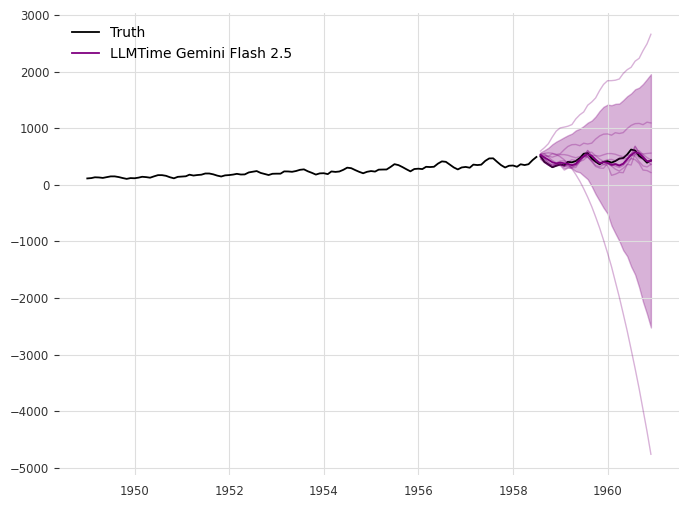

--------------------------------------------
--- Running model: LLMTime Gemini 2.5 Pro ---
Before execution, train data index ends with: DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')...
Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gemini-2.5-pro', 'temp': 0.3, 'alpha': 0.3, 'beta': 0.5, 'top_p': 0.5, 'basic': False, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=False, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


Generating 10 samples from Gemini (gemini-2.5-pro)...
  - Generating sample 1/10...
  - Generating sample 2/10...
  - Generating sample 3/10...
  - Generating sample 4/10...
  - Generating sample 5/10...
  - Generating sample 6/10...
  - Generating sample 7/10...
  - Generating sample 8/10...
  - Generating sample 9/10...
  - Generating sample 10/10...



100%|██████████| 1/1 [13:37<00:00, 817.46s/it]

After execution, train data index ends with: DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')...


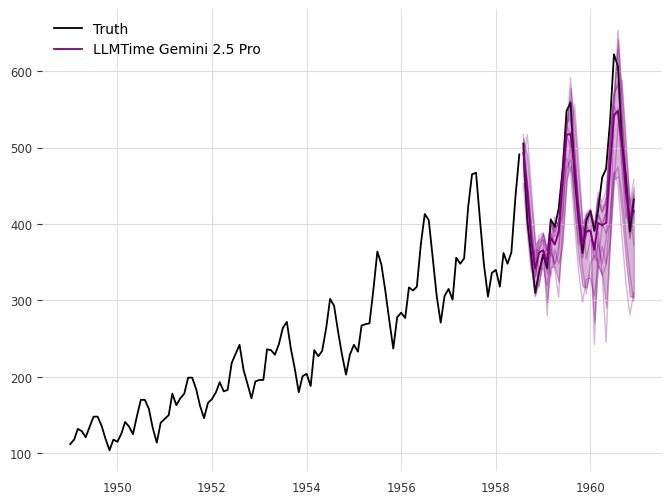

------------------------------------------
--- Running model: ARIMA ---
Before execution, train data index ends with: DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')...
Train length: 86, Val length: 29



/Users/woochul/workplace/projects/llmtime/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/woochul/workplace/projects/llmtime/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/woochul/workplace/projects/llmtime/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/woochul/workplace/projects/llmtime/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to conv

Sampling with best hyper... defaultdict(<class 'dict'>, {'p': 12, 'd': 2, 'q': 0}) 
 with NLL 3.742392


/Users/woochul/workplace/projects/llmtime/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/woochul/workplace/projects/llmtime/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


After execution, train data index ends with: DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01'],
              dtype='datetime64[ns]', name='Month', freq='MS')...


/Users/woochul/workplace/projects/llmtime/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


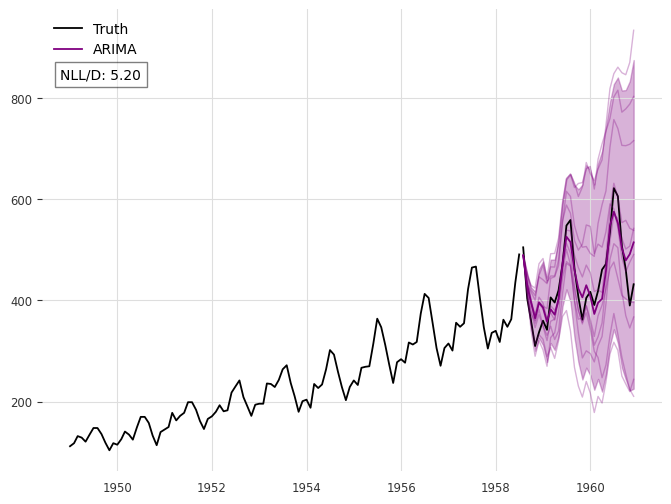

-------------------------


In [58]:
datasets = get_datasets()
ds_name = 'AirPassengersDataset'

data = datasets[ds_name]
train, test = data # or change to your own data
out = {}
for model in model_names: # GPT-4 takes a about a minute to run
    print(f"--- Running model: {model} ---")
    # Safe logging: Check if train object has an index before printing
    if hasattr(train, 'index'):
        print(f"Before execution, train data index ends with: {train.index[-5:]}...")
    else:
        print(f"Before execution, train data (last 5): {train[-5:]}...")

    if 'PromptCast' in model:
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
    hypers = list(grid_iter(model_hypers[model]))
    num_samples = 10

    # This protects the original train/test data from being modified by any model (like ARIMA).
    pred_dict = get_autotuned_predictions_data(train.copy(), test.copy(), hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
    out[model] = pred_dict
    
    # Safe logging: Check if train object has an index before printing
    if hasattr(train, 'index'):
        print(f"After execution, train data index ends with: {train.index[-5:]}...")
    else:
        print(f"After execution, train data (last 5): {train[-5:]}...")

    plot_preds(train, test, pred_dict, model, show_samples=True)
    print("-" * (20 + len(model)))
